# import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

# Reading the text file

In [ ]:
def read_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
data = read_file('/content/drive/MyDrive/MPT2/parser.txt')
data = data.split('\n')
data[:10]

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more']

In [ ]:
import string
charecters = string.ascii_letters + string.digits + string.punctuation
charecters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
a -> 0
0-> a

In [ ]:
charecters[10]

'k'

In [ ]:
#!tar -xzvf '/content/drive/MyDrive/MPT2/words.tgz' -C '/content/words'

# Encoder function

In [ ]:
charecters = string.ascii_letters + string.digits + string.punctuation
def encoder(txt):
    output = []
    for index, charecter in enumerate(txt):
        output.append(charecters.index(charecter))
    return output
print(charecters,len(charecters))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 94


In [ ]:
encoder('Move')

[38, 14, 21, 4]

# Processing the Image files

In [ ]:
def transform(image):
    width, height = image.shape
    
    new_width = 32
    new_height = 128
    
    #new_height = int(height * (new_width / width ))
    image = cv2.resize(image, (new_height , new_width))
    image = image.astype('float32')
    width , height = image.shape
    
    if width < 32:
        add_zeros = np.full((32-width, height), 255)
        image = np.concatenate((image , add_zeros))
        width , height = image.shape
        
    if width < 128:
        add_zeros = np.full((width, 128-height), 255)
        image = np.concatenate((image , add_zeros), axis=1)
        width , height = image.shape
        
    if height > 128 or width > 32:
        dim = (128,32)
        image = cv2.resize(image,dim)
        
    image = cv2.subtract(255, image)
    image = np.expand_dims(image, axis=2)
    image = image / 255
    return image

# Generating the training and validation data

In [ ]:
# # importing required modules
# from zipfile import ZipFile
  
# # specifying the zip file name
# file_name = "/content/drive/MyDrive/MTP2/words.zip"
  
# # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     #printing all the contents of the zip file
#     zip.printdir()
  
#     # extracting all the files
#     print('Extracting all the files now...')
#     #zip.extractall()
#     print('Done!')

!unzip "/content/drive/MyDrive/MPT2/words.zip"

Streaming output truncated to the last 5000 lines.
  inflating: words/p06/p06-088/p06-088-02-03.png  
  inflating: words/p06/p06-088/p06-088-02-04.png  
  inflating: words/p06/p06-088/p06-088-02-05.png  
  inflating: words/p06/p06-088/p06-088-02-06.png  
  inflating: words/p06/p06-088/p06-088-02-07.png  
  inflating: words/p06/p06-088/p06-088-02-08.png  
  inflating: words/p06/p06-088/p06-088-03-00.png  
  inflating: words/p06/p06-088/p06-088-03-01.png  
  inflating: words/p06/p06-088/p06-088-03-02.png  
  inflating: words/p06/p06-088/p06-088-03-03.png  
  inflating: words/p06/p06-088/p06-088-03-04.png  
  inflating: words/p06/p06-088/p06-088-03-05.png  
  inflating: words/p06/p06-088/p06-088-03-06.png  
  inflating: words/p06/p06-088/p06-088-03-07.png  
  inflating: words/p06/p06-088/p06-088-03-08.png  
  inflating: words/p06/p06-088/p06-088-04-00.png  
  inflating: words/p06/p06-088/p06-088-04-01.png  
  inflating: words/p06/p06-088/p06-088-04-02.png  
  inflating: words/p06/p06-088/

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

max_len = 0

for index, line in enumerate(data):
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0], splits_id[1],word_id)
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = transform(img)
        except:
            continue
        # processing on label
        try:
            label = encoder(word)
        except:
            continue
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_len:
            max_len = len(word)
    if index >= 10000:
        break

# Padding the sequence

In [ ]:
max_len = 16

In [ ]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_len, 
                             padding='post',
                             value=len(charecters))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_len, 
                             padding='post',
                             value=len(charecters))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# Create a model for training

- Add several CNN layers to extract the sequence of features

In [ ]:
from keras.layers.convolutional import Conv2D

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
#convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
#pooling layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

#pooling layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

#Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
#bidirectional LSTM layers with units=256 and dropout=0.5
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.5))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.5))(blstm_1)

#dense layer with activation=softmax 
#outputs = Dense(len(chars)+1, activation = 'softmax')(blstm_2)
outputs = Dense(len(charecters)+1, activation = 'softmax')(blstm_2)
#model to be used for testing
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
#LOSS FUNCTION:

labels = Input(name='labels', shape=[16], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])


In [ ]:
#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss)

batch_size = 16
epochs = 10
e = str(epochs)
optimizer = 'Adam'

#model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer, metrics=['accuracy'])

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer, metrics=['accuracy'])
# callbacks function
filepath="models/model-{}e-{}o.h5".format(str(epochs),str(optimizer))
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]





history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/10
491/491 [==============================] - ETA: 0s - loss: 14.8609 - accuracy: 2.5478e-04
Epoch 00001: val_loss improved from inf to 12.70369, saving model to models/model-10e-Adamo.h5
491/491 [==============================] - 1390s 3s/step - loss: 14.8609 - accuracy: 2.5478e-04 - val_loss: 12.7037 - val_accuracy: 0.0034
Epoch 2/10
491/491 [==============================] - ETA: 0s - loss: 11.3687 - accuracy: 0.0304
Epoch 00002: val_loss improved from 12.70369 to 11.15813, saving model to models/model-10e-Adamo.h5
491/491 [==============================] - 1389s 3s/step - loss: 11.3687 - accuracy: 0.0304 - val_loss: 11.1581 - val_accuracy: 0.0388
Epoch 3/10
491/491 [==============================] - ETA: 0s - loss: 9.1491 - accuracy: 0.0605
Epoch 00003: val_loss improved from 11.15813 to 9.68465, saving model to models/model-10e-Adamo.h5
491/491 [==============================] - 1388s 3s/step - loss: 9.1491 - accuracy: 0.0605 - val_loss: 9.6846 - val_accuracy: 0.0845
Epoch

# CTC layer- CTC decode and Prediction


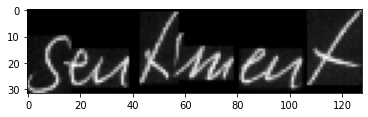

original_text  =  Labour
predicted text =  large

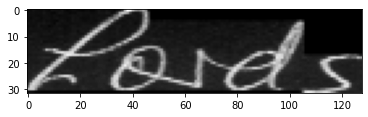

original_text  =  absolutely
predicted text =  majority

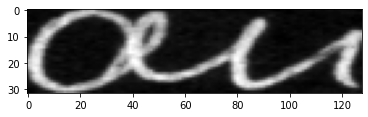

original_text  =  nor
predicted text =  of

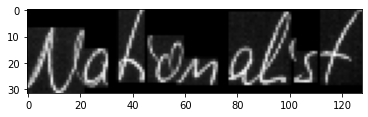

original_text  =  was
predicted text =  Labour

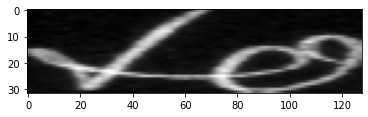

original_text  =  and
predicted text =  Ms

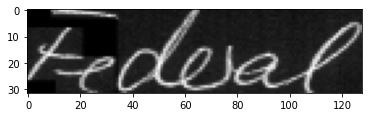

original_text  =  benches
predicted text =  are

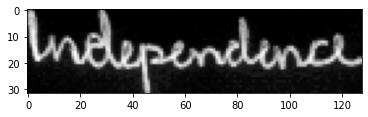

original_text  =  strain
predicted text =  to

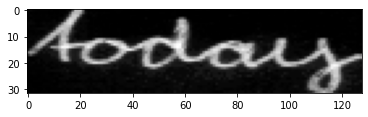

original_text  =  their
predicted text =  tn

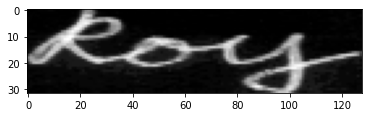

original_text  =  different
predicted text =  down

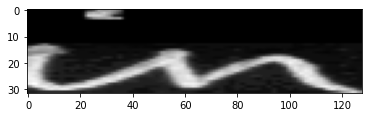

original_text  =  ambulance
predicted text =  the

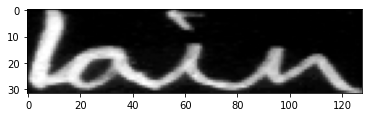

original_text  =  not
predicted text =  Foot-

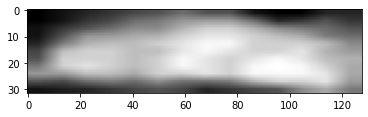

original_text  =  Answering
predicted text =  be

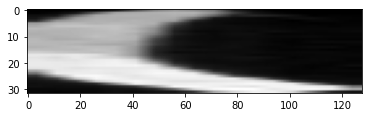

original_text  =  ceiling
predicted text =  that

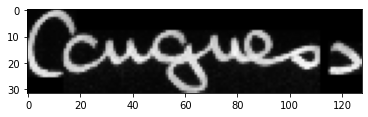

original_text  =  reminded
predicted text =  a

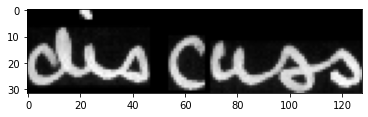

original_text  =  because
predicted text =  Labos

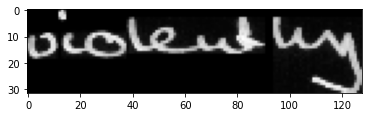

original_text  =  in
predicted text =  MPs

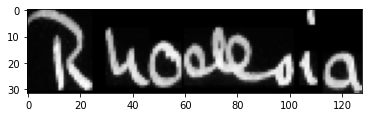

original_text  =  expenditure
predicted text =  oppored

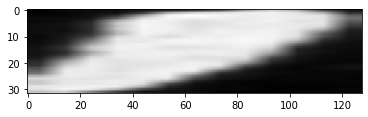

original_text  =  cent.
predicted text =  the

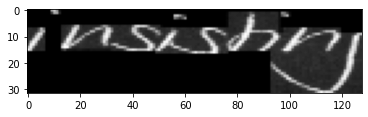

original_text  =  unsmiling
predicted text =  Bill

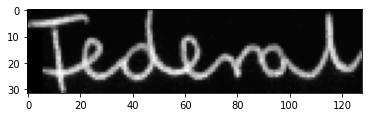

original_text  =  it
predicted text =  which

In [ ]:
decoded = K.ctc_decode(prediction,input_length=np.ones(prediction.shape[0]) * prediction.shape[1],greedy=True)[0][0]
output = K.get_value(decoded)

#visualize the results:

# see the results
for i, x in enumerate(output):
    plt.imshow(valid_images[45+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print("original_text  = ", valid_original_text[345+i])
    print("predicted text =  ", end = '')
    for p in x:
        if int(p) != -1:
            print(charecters[int(p)], end = '')


In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 110 kB 5.4 MB/s 
     |████████████████████████████████| 854 kB 52.7 MB/s 


In [ ]:
# load the saved best model weights
act_model.load_weights('/content/models/model-10e-Adamo.h5')

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=charecters[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.8159206544765906
ratio: 0.7767296882719311


original_text =   large
predicted text = large

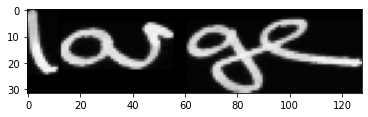



original_text =   majority
predicted text = majority

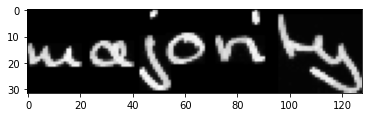



original_text =   of
predicted text = of

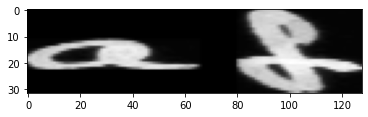



original_text =   Labour
predicted text = Labour

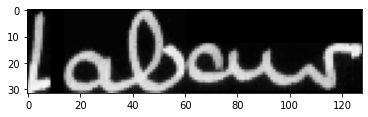



original_text =   MPs
predicted text = Ms

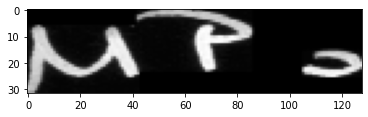



original_text =   are
predicted text = are

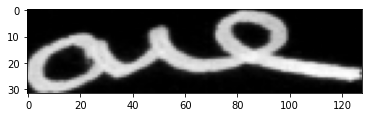



original_text =   to
predicted text = to

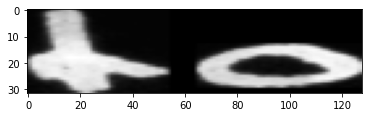



original_text =   turn
predicted text = tn

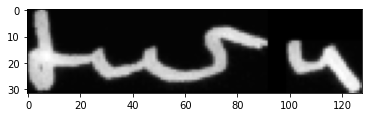



original_text =   down
predicted text = down

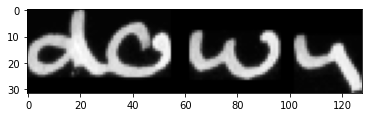



original_text =   the
predicted text = the

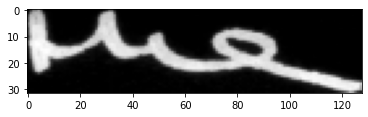



original_text =   Foot-
predicted text = Foot-

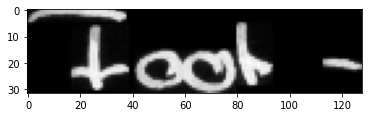



original_text =   be
predicted text = be

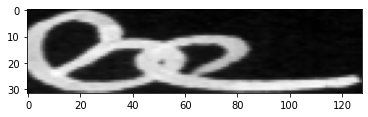



original_text =   that
predicted text = that

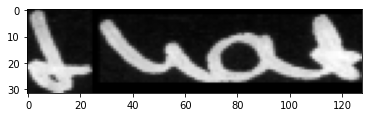



original_text =   as
predicted text = a

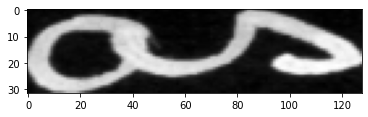



original_text =   Labour
predicted text = Labos

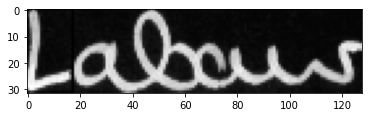



original_text =   MPs
predicted text = MPs

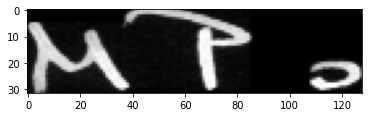



original_text =   opposed
predicted text = oppored

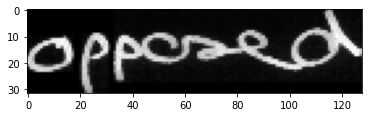



original_text =   the
predicted text = the

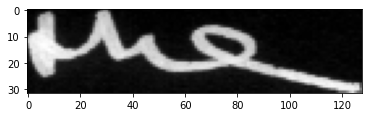



original_text =   Bill
predicted text = Bill

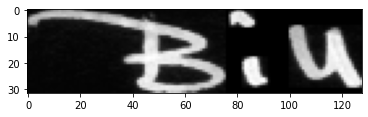



original_text =   which
predicted text = which

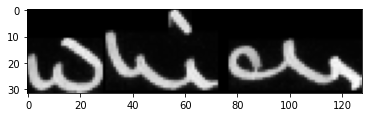

In [ ]:
# predict outputs on validation images
prediction = act_model.predict(train_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(charecters[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')